# Thermal conductivity from BTE

Here, we provide an introductory tutorial on how to use [phono3py](https://phonopy.github.io/phono3py/) to compute the thermal conductivity using a neuroevolution potential (NEP) via the Boltzmann transport equation (BTE).
The system under study is graphite represented by a NEP model developed in [this paper](http://doi.org/10.1021/acsnano.3c09717).
Note that `phono3py` also allows you to compute other phonon properties such as, e.g., phonon lifetimes.

All models and structures required for running this and the other tutorial notebooks can be obtained from [Zenodo](https://zenodo.org/record/10658778).
The files are also available in the `tutorials/` folder in the [GitLab repository](https://gitlab.com/materials-modeling/calorine/-/tree/master/tutorials).

## Workflow

The steps required are:

1. Relax the primitive cell
2. Compute the force constants (`fc2.hdf5`, `fc3.hdf5`) using the NEP model for all structures generated by `phono3py`
3. Run the thermal conductivity calculation

Since `phono3py` does not have a python API we will call it through its command line interface via the `os.system` function.


## BTE computational parameters

**Note 1:**
In order to achive converged force constants one must use a sufficiently large supercell, the size of which is specified via the `--dim` option.
Here, we, however, use a rather small supercell in order for the tutorial to run faster.

**Note 2:**
Here, we use the `phono3py` default displacement amplitude of 0.03 Å when generating supercells for the force-constant extraction.
This may not be suitable for every materials.

**Note 3:**
In order to achieve convergence of the thermal conductivity one should use a larger q-point mesh (`--mesh`), but here we use a rather small mesh in order for the tutorial to complete within an acceptable time.

**Note 4:**
In order to obtain accurate predictions for the thermal conductivity in graphite one should employ the `--lbte` (see [here](https://phonopy.github.io/phono3py/direct-solution.html) for more information).
This method is, however, more costly both computationally and with respect to memory.
For simpliticity we therefore limit ourselves to the relaxation time approximation (RTA), which is invoked via the `--bterta` option.

## Miscellaneous

Additional related tutorials can be found on the [hiphive website](https://hiphive.materialsmodeling.org/tutorial/compute_third_order_properties.html) and [here](https://hiphive.materialsmodeling.org/tutorial/compute_third_order_properties.html).

In [1]:
import os
import shutil
from glob import glob

import numpy as np
import h5py

from ase.io import read, write
from calorine.calculators import CPUNEP
from calorine.tools import relax_structure
from matplotlib import pyplot as plt

## Preparations

We start out by setting up the working directory for the `phono3py` calculations.

In [2]:
root_dir = os.getcwd()  # here we set the root directory
work_dir = os.path.join(root_dir, 'phono3py_workdir')
shutil.rmtree(work_dir, ignore_errors=True)  # Deletes current working dir
os.mkdir(work_dir)
os.chdir(work_dir)

print(f'Root directory: {root_dir}')
print(f'Working directory: {work_dir}')

Root directory: /home/erhart/repos/calorine/tutorials
Working directory: /home/erhart/repos/calorine/tutorials/phono3py_workdir


## Relaxation of primitive cell

First, we relax the primitive graphite unit cell (4-atoms) with respect to ionic positions and cell metric.
To obtain accurate force constants it is recommended to use a tight convergence condition, i.e., a small value for the termination condition `fmax`.

In [3]:
potential_filename = os.path.join(root_dir, 'nep-graphite-CX.txt')
prim = read(os.path.join(root_dir, 'graphite-prim.xyz'))
prim.calc = CPUNEP(potential_filename)
relax_structure(prim, fmax=1e-5)

## Construction of force constants

Next, we construct the force constants.
Here, we use the approach implemented in `phono3py`, which generates the second and third force constants by systematic enumeration and numerical evaluation of the derivatives involved.
Especially for more complex materials, say systems with larger unit cells and/or lower symmetry, it can be beneficial to use regression based approaches such as the one implemented in, e.g., [hiphive](https://hiphive.materialsmodeling.org/).

First, we call `phono3py` to generate a series of configurations (supercells) with systematic displacements.

In [4]:
# supercell size
dim = (4, 4, 2)

cmd = f'phono3py -d --dim="{dim[0]} {dim[1]} {dim[2]}" --dim-fc2="{dim[0]} {dim[1]} {dim[2]}"'

write('POSCAR', prim)

print(f'Running command: {cmd}')
os.system(cmd);

Running command: phono3py -d --dim="4 4 2" --dim-fc2="4 4 2"
        _                      _____
  _ __ | |__   ___  _ __   ___|___ / _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ |_ \| '_ \| | | |
 | |_) | | | | (_) | | | | (_) |__) | |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___/____/| .__/ \__, |
 |_|                                |_|    |___/ 
                                       2.6.0

-------------------------[time 2023-04-18 18:57:09]-------------------------
Compiled with OpenMP support (max 8 threads).
Python version 3.9.12
Spglib version 1.16.5

Unit cell was read from "POSCAR".
Displacement distance: 0.03
Number of displacements: 1220
Number of displacements for special fc2: 1220
Spacegroup: P6_3/mmc (194)
Displacement dataset was written in "phono3py_disp.yaml".
-------------------------[time 2023-04-18 18:57:11]-------------------------
                 _
   ___ _ __   __| |
  / _ \ '_ \ / _` |
 |  __/ | | | (_| |
  \___|_| |_|\__,_|



Next we compute the forces for the second-order force constants.

In [5]:
fnames = sorted(glob('POSCAR_FC2-*'))
forces_data = []
for it, fname in enumerate(fnames):
    structure = read(fname)
    structure.calc = CPUNEP(potential_filename)
    forces = structure.get_forces()
    forces_data.append(forces)
    print(f'FC2: Calculating supercell {it:5d} / {len(fnames)}, f_max {np.max(np.abs(forces)):8.5f}')
forces_data = np.array(forces_data).reshape(-1, 3)
np.savetxt('FORCES_FC2', forces_data)

FC2: Calculating supercell     0 / 4, f_max  1.85218
FC2: Calculating supercell     1 / 4, f_max  0.42094
FC2: Calculating supercell     2 / 4, f_max  1.85890
FC2: Calculating supercell     3 / 4, f_max  0.41891


Followed by the forces for the third-order force constants.

In [6]:
fnames = sorted(glob('POSCAR-*'))
forces_data = []
for it, fname in enumerate(fnames):
    structure = read(fname)
    structure.calc = CPUNEP(potential_filename)
    forces = structure.get_forces()
    forces_data.append(forces)
    if it % 100 == 0:
        print(f'FC3: Calculating supercell {it:5d} / {len(fnames)}, f_max= {np.max(np.abs(forces)):8.5f}')
forces_data = np.array(forces_data).reshape(-1, 3)
np.savetxt('FORCES_FC3', forces_data)

FC3: Calculating supercell     0 / 1220, f_max=  1.85218
FC3: Calculating supercell   100 / 1220, f_max=  1.85218
FC3: Calculating supercell   200 / 1220, f_max=  1.85217
FC3: Calculating supercell   300 / 1220, f_max=  1.85213
FC3: Calculating supercell   400 / 1220, f_max=  1.85216
FC3: Calculating supercell   500 / 1220, f_max=  0.43240
FC3: Calculating supercell   600 / 1220, f_max=  1.57674
FC3: Calculating supercell   700 / 1220, f_max=  1.85890
FC3: Calculating supercell   800 / 1220, f_max=  1.85313
FC3: Calculating supercell   900 / 1220, f_max=  1.85893
FC3: Calculating supercell  1000 / 1220, f_max=  1.85861
FC3: Calculating supercell  1100 / 1220, f_max=  1.11016
FC3: Calculating supercell  1200 / 1220, f_max=  1.85924


Finally, we can combine the forces to construct force constants.

In [7]:
cmd = f'phono3py --cfc --hdf5-compression gzip --dim="{dim[0]} {dim[1]} {dim[2]}" --dim-fc2="{dim[0]} {dim[1]} {dim[2]}"'
print(f'Running command: {cmd}')
os.system(cmd);

Running command: phono3py --cfc --hdf5-compression gzip --dim="4 4 2" --dim-fc2="4 4 2"
        _                      _____
  _ __ | |__   ___  _ __   ___|___ / _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ |_ \| '_ \| | | |
 | |_) | | | | (_) | | | | (_) |__) | |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___/____/| .__/ \__, |
 |_|                                |_|    |___/ 
                                       2.6.0

-------------------------[time 2023-04-18 18:57:36]-------------------------
Compiled with OpenMP support (max 8 threads).
Python version 3.9.12
Spglib version 1.16.5
----------------------------- General settings -----------------------------
Run mode: None
HDF5 data compression filter: gzip
Crystal structure was read from "POSCAR".
Supercell (dim): [4 4 2]
Phonon supercell (dim-fc2): [4 4 2]
Spacegroup: P6_3/mmc (194)
Use -v option to watch primitive cell, unit cell, and supercell structures.
----------------------------- Force constants ------------------------------
Imp

## BTE calculation

Having prepared the force constants we are now in a position to carry out the calculation of the lattice thermal conductivity.
Note that the following cell can take a couple of minutes to run.
Since by default `phono3py` produces a lot of output during the execution of this task, the output is turned off here via the `-q` option.

In [8]:
mesh = [16, 16, 8]  # q-point mesh
T_min, T_max = 10, 1000  # temperature range
T_step = 10  # spacing of temperature points

cmd = f'phono3py -q --fc2 --fc3 --bterta --dim="{dim[0]} {dim[1]} {dim[2]}" --dim-fc2="{dim[0]} {dim[1]} {dim[2]}"'\
      f' --tmin={T_min} --tmax={T_max} --tstep={T_step} --mesh "{mesh[0]} {mesh[1]} {mesh[2]}"'
print(f'Running command: {cmd}')

os.system(cmd);

Running command: phono3py -q --fc2 --fc3 --bterta --dim="4 4 2" --dim-fc2="4 4 2" --tmin=10 --tmax=1000 --tstep=10 --mesh "16 16 8"


After the calculation has concluded, we return to the original directory.

In [9]:
os.chdir(root_dir)

## Analysis of  results

We can now read the results of the BTE calculations from the `kappa-<mesh>.hdf5` file (where `<mesh>` specicifies the q-point mesh used for the calculation).
For more information about the content of the `kappa-<mesh>.hdf5` file see [here](https://phonopy.github.io/phono3py/hdf5_howto.html#).

In [10]:
fobj = h5py.File(f'{work_dir}/kappa-m{mesh[0]}{mesh[1]}{mesh[2]}.hdf5')
print('Data:')
for key in fobj:
    print(f'  {key:25} : array-shape {fobj[key].shape}')

temperatures = fobj['temperature'][:]
kappa = fobj['kappa'][:]
gamma = fobj['gamma'][:]
freqs = fobj['frequency'][:]
fobj.close()

Data:
  frequency                 : array-shape (150, 12)
  gamma                     : array-shape (100, 150, 12)
  grid_point                : array-shape (150,)
  group_velocity            : array-shape (150, 12, 3)
  gv_by_gv                  : array-shape (150, 12, 6)
  heat_capacity             : array-shape (100, 150, 12)
  kappa                     : array-shape (100, 6)
  kappa_unit_conversion     : array-shape ()
  mesh                      : array-shape (3,)
  mode_kappa                : array-shape (100, 150, 12, 6)
  qpoint                    : array-shape (150, 3)
  temperature               : array-shape (100,)
  version                   : array-shape ()
  weight                    : array-shape (150,)


Here, `kappa` is an array of shape `(number of temperatures, 6)`, where the 6 indices corresponds to the `xx`, `yy`, `zz`, `yz`, `xz`, and `xy` elements of the thermal conductivity tensor.

For the temperature dependence of the thermal conductivity, we obtain the following.

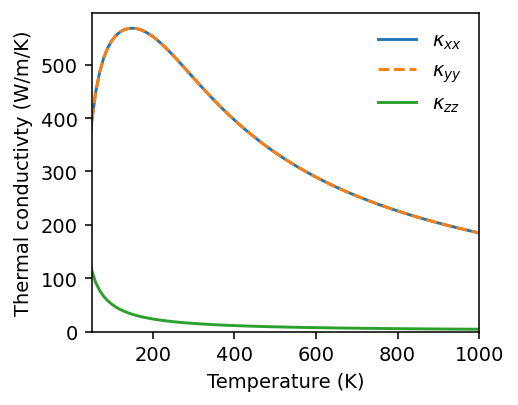

In [11]:
fig, ax = plt.subplots(figsize=(3.8, 3), dpi=140)

ax.plot(temperatures, kappa[:, 0], '-', label=r'$\kappa_{xx}$')
ax.plot(temperatures, kappa[:, 1], '--', label=r'$\kappa_{yy}$')
ax.plot(temperatures, kappa[:, 2], '-', label=r'$\kappa_{zz}$')
ax.legend(loc='upper right', frameon=False)

ax.set_xlim([50, temperatures.max()])
ax.set_ylim([0, np.max(kappa)*1.05])

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Thermal conductivty (W/m/K)')

fig.tight_layout()

Similarly, we can visualize lifetimes.

Temperature 100.0
Temperature 300.0
Temperature 1000.0


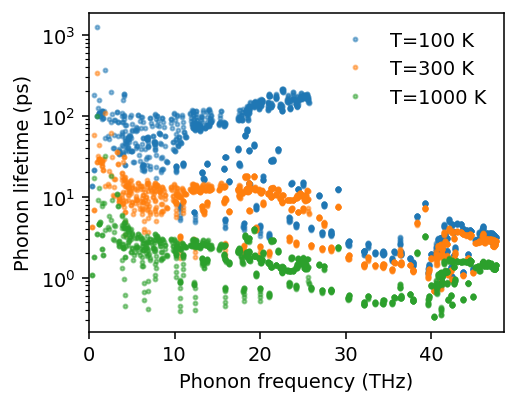

In [12]:
fig, ax = plt.subplots(figsize=(3.8, 3), dpi=140)

T_index = 29
T_indices = [9, 29, 99]
for T_index in T_indices:

    print(f'Temperature {temperatures[T_index]}')
    g = gamma[T_index].flatten()
    g = np.where(g > 0.0, g, -1)
    lifetimes = np.where(g > 0.0, 1.0 / (2 * 2 * np.pi * g), np.nan)

    ax.semilogy(freqs.flatten(), lifetimes, 'o', label=f'T={temperatures[T_index]:.0f} K', alpha=0.5, markersize=2)

ax.legend(loc='upper right', frameon=False)
ax.set_xlabel('Phonon frequency (THz)')
ax.set_ylabel('Phonon lifetime (ps)')

ax.set_xlim([0, freqs.max()*1.02])

fig.tight_layout()